# DFT and/vs LSTM for time series prediction

## DFT

### Theory recap

Note: 
- We'll only deal with Real valued signals
- We'll use torch as we'll deal with LSTMs later, but the commands for numpy and scipy are almost identical.
- We'll set the sample rate `fs=1`

First let's review some things that we need to know about the Discrete Fourier Transform (DFT)

**1) FFT stands for Fast Fourier Transform and is the `O(nlog(n))` algorithm typically used to compute the DFT.**

Hence torch.fftm numpy.fft, scipy.fft.

**2) The DFT is a linear operation that maps a signal of N samples onto N complex values which represent the amplitudes and phases of the harmonics/components that make up the signal.**

The frequencies of these components are determined by `N` and the sample rate `fs`: `f[k]=k*fs/N`, or simply `f[k]=k/N` in our case.

**3) While there are N components in the DFT, these only correspond to about `N/2` different and unique fundamental frequencies.**

That is becasue the DFT maps the signal onto a given positive frequency and its negative separately. The two are functionally equivalent and when dealing with real valued signals the two corresponding amplitueds are added together and we just work with the positive frequency.

Specifically we have,

if N is even:
- `N/2`  positive frequency components, including the DC component (the constant value/offset of the signal). 
- `1` value for the Nyquist component `fs/2` (the highest possible frequency) 
- So `N/2+1` in total.

The frequencies will be `f = [0, 1/N, 2/N, ..., 1/2]`

The periods will be     `T = [0, N, N/2, ..., 2]`

if N is odd:
- `(N+1)/2`  positive frequency components including the DC component.
-  Note that we don't reach the Nyquist component in this case, the highest frequency component in the DFT will be slightly below it.

The frequencies will be `f = [0, 1/N, 2/N, ..., 1/2 - 1/2N]`

The periods will be     `T = [0, N, N/2, ..., 2N/(N-1)]`


Let's explore the above in torch and see if we get what we expect.

In [1]:
import torch
# Even N
print("EVEN")
N = 16
expected_components = N/2 + 1
y = torch.arange(N)
dft = torch.fft.rfft(y)
assert int(expected_components) == len(dft)
print(len(dft), expected_components, dft.dtype)

f = torch.fft.rfftfreq(N)
T = 1/torch.fft.rfftfreq(N)
T[0]=0
print(f)
print(T)

# Odd N
print("ODD")
N=15
expected_components = (N+1)/2
y = torch.arange(N)
dft = torch.fft.rfft(y)
assert int(expected_components) == len(dft)
print(len(dft), expected_components, dft.dtype)

f = torch.fft.rfftfreq(N)
T = 1/torch.fft.rfftfreq(N)
T[0]=0
print(f)
print(T)


EVEN
9 9.0 torch.complex64
tensor([0.0000, 0.0625, 0.1250, 0.1875, 0.2500, 0.3125, 0.3750, 0.4375, 0.5000])
tensor([ 0.0000, 16.0000,  8.0000,  5.3333,  4.0000,  3.2000,  2.6667,  2.2857,
         2.0000])
ODD
8 8.0 torch.complex64
tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667])
tensor([ 0.0000, 15.0000,  7.5000,  5.0000,  3.7500,  3.0000,  2.5000,  2.1429])


To get the corresponding aplitudes we do:

In [2]:
amplitudes = torch.abs(dft) / N # Scale by N to retieve the actual valued of the amplitudes of the harmonics
phases = torch.angle(dft)
print(len(amplitudes), amplitudes)
print(len(phases), phases)

8 tensor([7.0000, 2.4049, 1.2293, 0.8507, 0.6728, 0.5774, 0.5257, 0.5028])
8 tensor([0.0000, 1.7802, 1.9897, 2.1991, 2.4086, 2.6180, 2.8274, 3.0369])


### Exploration: DFT in pratice

Let's familiarize whith how the DFT works in practice.

While obtaining values for the amplitudes, pahses, frequencies etc...is intersting it doe snto help much in understadning.
What is more helpful is to understand the opposite direction of how the frequencies come together to build the signal and predict the signal beyond the sampling window.

So we will do `signal -> dft -> mess with the dft -> see how well the signal is reconstructed inside and outside the sampling window. `

Let's define some helper functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import wandb
from pathlib import Path

np.random.seed(0)  # Seed for reproducibility

def generate_signal(num_samples=200, noise=False, num_components=(3, 7), periods_range=(2, 100)):
    """
    :param num_samples: Total number of samples in the signal
    :return: 
    """        
    if type(num_components) == int:
        num_components = (num_components, num_components+1)
    else:
        assert num_components[0] < num_components[1]
    if type(periods_range) == int:
        periods_range = (periods_range, periods_range+1)
    else:
        assert periods_range[0] <= periods_range[1]

    num_components = np.random.randint(*num_components)  # Randomly choose how many periods to combine
    
    periods = np.random.randint(*periods_range, num_components)  # Period lengths in samples
    phases = np.random.rand(num_components) * 2 * np.pi
    amplitudes = np.random.rand(num_components)
    amplitudes /= np.sum(amplitudes)

    # Sample indices
    samples = np.arange(num_samples)

    # Generate a random continuous periodic signal
    signal = sum(amplitude * np.sin(2 * np.pi * (1 / period) * samples + phase) for amplitude, period, phase in zip(amplitudes, periods, phases))
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # Add random noise to the signal
    if noise:
        noise = np.random.normal(0, 0.1, signal.shape)
        signal += noise
        signal = signal / np.max(np.abs(signal))  # Normalize signal again

    return torch.from_numpy(samples).to(torch.float), torch.from_numpy(signal).to(torch.float)



def get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing=False):
    if hamming_smoothing:
        signal_window = orignal_signal[:analysis_samples]
        window = torch.hamming_window(analysis_samples, periodic=False)
        signal_window = signal_window * window
        fft_result = torch.fft.rfft(signal_window)
    else:
        fft_result = torch.fft.rfft(orignal_signal[:analysis_samples])
    amplitudes = torch.abs(fft_result) / analysis_samples
    phases = torch.angle(fft_result)
    
    # Double the amplitudes for non-DC components
    # Note: The last component should not be doubled if N is even and represents the Nyquist frequency
    if analysis_samples % 2 == 0:
        # If the original signal length is even, don't double the last component (Nyquist frequency)
        amplitudes[1: -1] *= 2
    else:
        # If the original signal length is odd, all components except the DC can be doubled
        amplitudes[1:] *= 2
    return amplitudes, phases

def get_signal_from_harmonics(amplitudes, phases, num_samples):
    analysis_samples = len(amplitudes) * 2 - 2  # Adjust for rfft output length
    reconstructed_signal = torch.zeros(num_samples, dtype=torch.complex64)
    for index, (amplitude, phase) in enumerate(zip(amplitudes, phases)):
        reconstructed_signal += amplitude * torch.exp(1j * (2 * torch.pi * index * torch.arange(num_samples) / analysis_samples + phase))

    # Return the real part of the reconstructed signal
    return reconstructed_signal.real


def reconstruct_signal_fft(orignal_signal, analysis_samples, hamming_smoothing=False):
    # Perform FFT on the entire signal
    amplitudes, phases = get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing)

    # Return the real part of the reconstructed signal
    return get_signal_from_harmonics(amplitudes, phases, len(orignal_signal))


We can use `generate_signal` to produce a random signal. We can get a non radom output for just one compoentn with a specified periodicity.

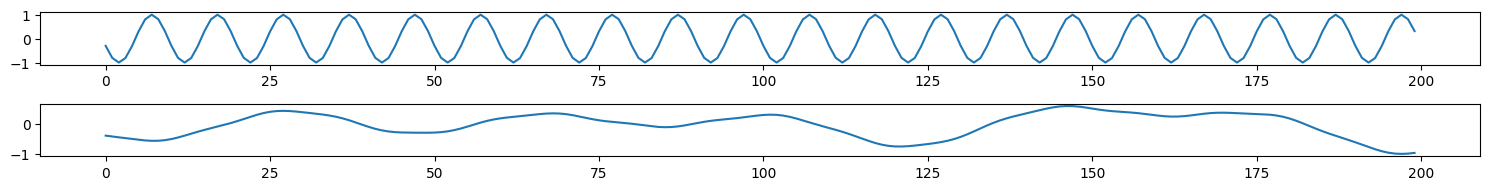

In [5]:
plt.figure(figsize=(15, 2))

plt.subplot(2, 1, 1)
# signal with 1 component with a period of 10 samples
x,y  = generate_signal(num_components=1, periods_range=10)
plt.plot(x,y)
plt.subplot(2, 1, 2)
# signal with a random amount of components and periods
x,y  = generate_signal()
plt.plot(x,y)

plt.tight_layout()
plt.show()



Let's now define a function that takes care of plotting the original signal, the reconstructed signal and the amplitudes and phases of the harmonics.

In [23]:

def plot_signal_and_fft(signal: torch.Tensor, train_test_split_idx: int, hamming_smoothing: bool = False):
    assert (W := signal.shape[0]) >= train_test_split_idx
    t_full = torch.arange(W)


    amplitudes, phases = get_fft_harmonics(signal, train_test_split_idx, hamming_smoothing)
    frequency_bins = np.arange(len(amplitudes), dtype=np.float16)

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(t_full, signal, label="original")
    plt.plot(t_full, get_signal_from_harmonics(amplitudes, phases, W), '-x', label="fft reconstruction")
    plt.axvspan(0, train_test_split_idx-1, color='grey', alpha=0.3)
    plt.xlabel('t [samples]')
    plt.legend(loc='best')
    plt.title('Signal')
    
    fft_frequencies = frequency_bins/train_test_split_idx
    plt.subplot(1, 3, 2)
    plt.xscale('log')
    plt.plot(fft_frequencies, amplitudes)
    plt.xlabel('Frequency [1/samples]')
    plt.title('Amplitudes')

    fft_periods = frequency_bins.copy()
    fft_periods[1:]=train_test_split_idx/fft_periods[1:]
    plt.subplot(1, 3, 3)
    plt.plot(frequency_bins, amplitudes)
    top_5_indices = np.argsort(amplitudes)[-4:]
    top_5_indices[0]=1
    plt.xscale('log')
    plt.xticks(frequency_bins[top_5_indices],fft_periods[top_5_indices], rotation=70)
    plt.xlabel('T [samples]')
    plt.title('Amplitudes')


    plt.tight_layout()
    plt.show()



Now let's start applying the DFT to 1 component and see how we do.
Let's generate 200 samples and do the DFT on the first 100.

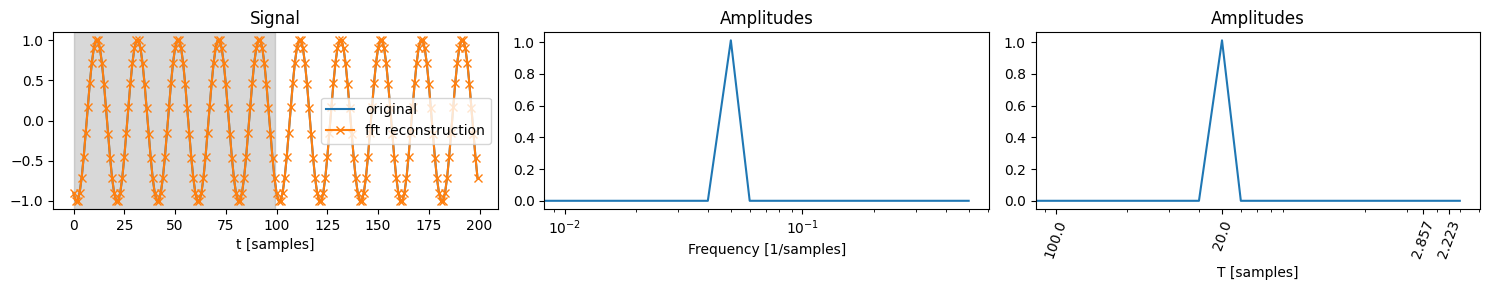

In [24]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 100)

Perfection! The DFT correctyl detects that we have 1 harmonic with a period of 20 samples, and our reconstruction then of course is also spot on outside of th fist 100 samples we did the DFT on.

We tried on 100 samples, then 110 samples must be even better! Let's try.

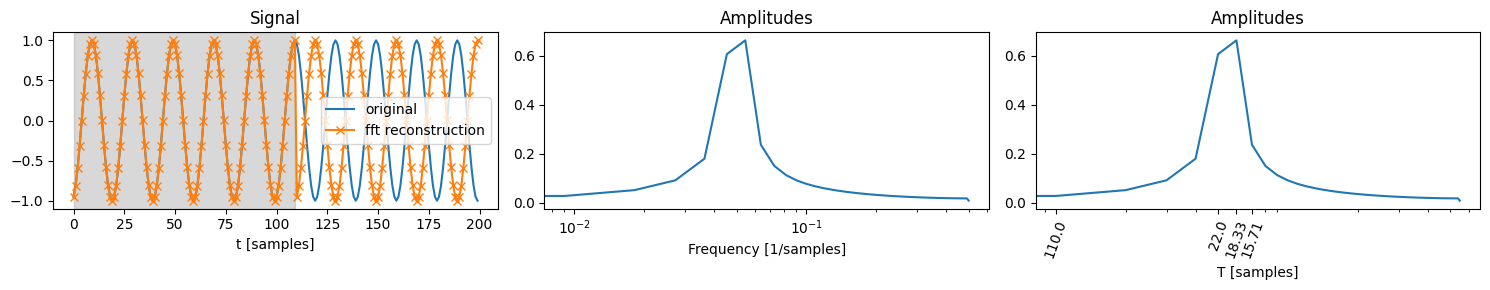

In [175]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 110)

Ouch that is not what one could have hoped for. Why?

**Becasue the DFT "assumes" that all components have a periodicity that completes an integer number of cycles within the sampling window.**

But a sinusoid with a period of 20 does not complete an integre number of cycles in 120 samples. Teh consequence is that the power of the signal get's spread out a bit over more frequencies (amplitude peak is not perfectly narrow on 20). This is known as spectral lekage.

Moreover our "prediction" of the signal outside the sampling window becomes terrible, as the reconstructed signal is just a copy of  the signal inside the sampling window. This is exactly what the DFT assumes: that the sample window we provide it is exactly the period of the signal (up to an integer factor)!

One way to reduce spectral leakage is having smoothing of the signal at the edges of the sampling window towards 0. 

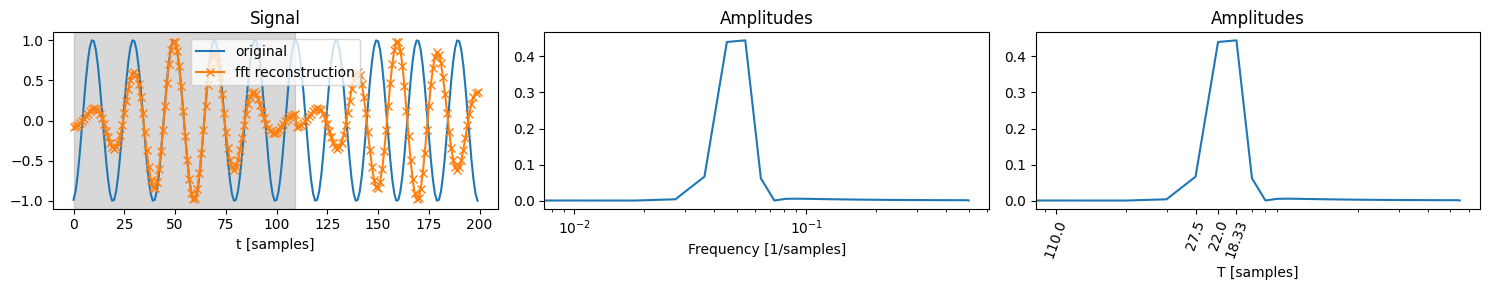

In [176]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 110, hamming_smoothing=True)

This localizes the amplitude peak a bit more, but it certianly doesn't help with the predicitve qualities of out reconstruction

Before we move on let's just look at the DFT of a more complex signal.

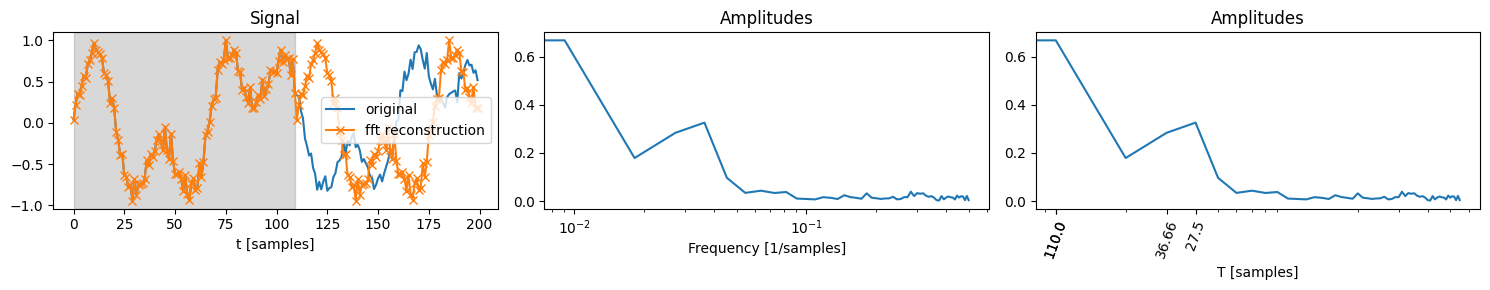

In [54]:
_, y = generate_signal(200, noise=True)
plot_signal_and_fft(y, 110)

###  With Real data

768


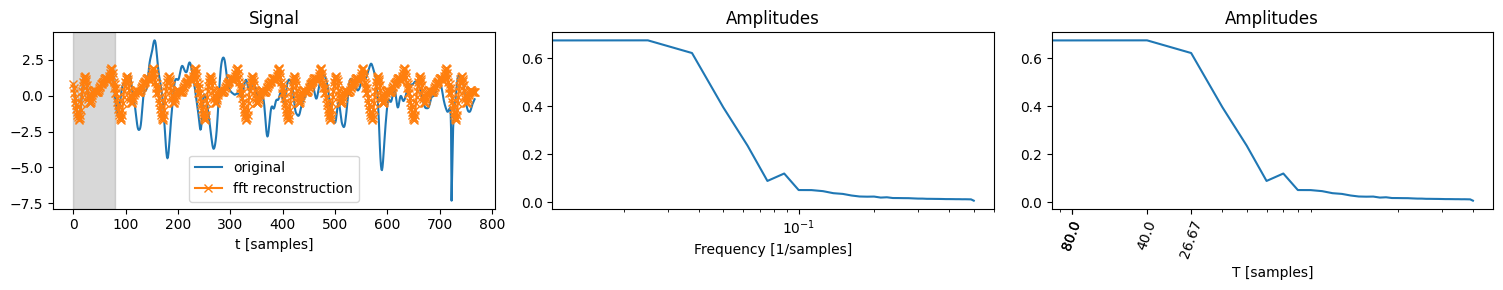

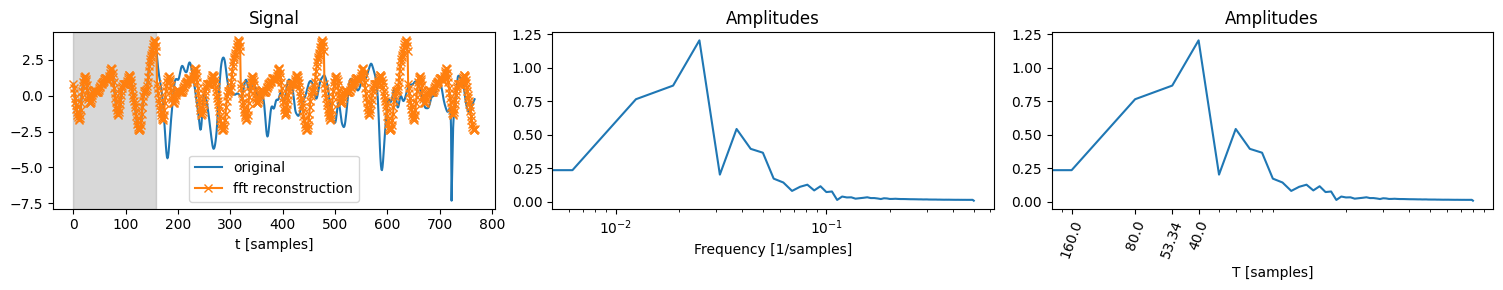

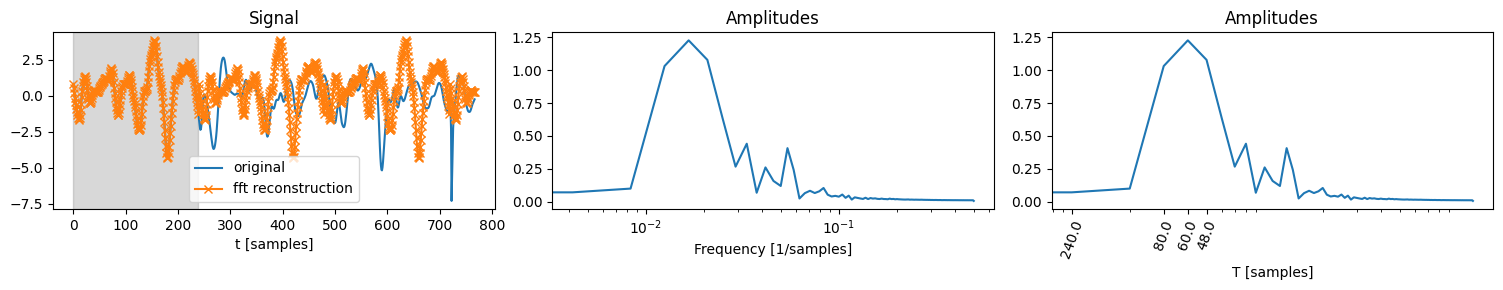

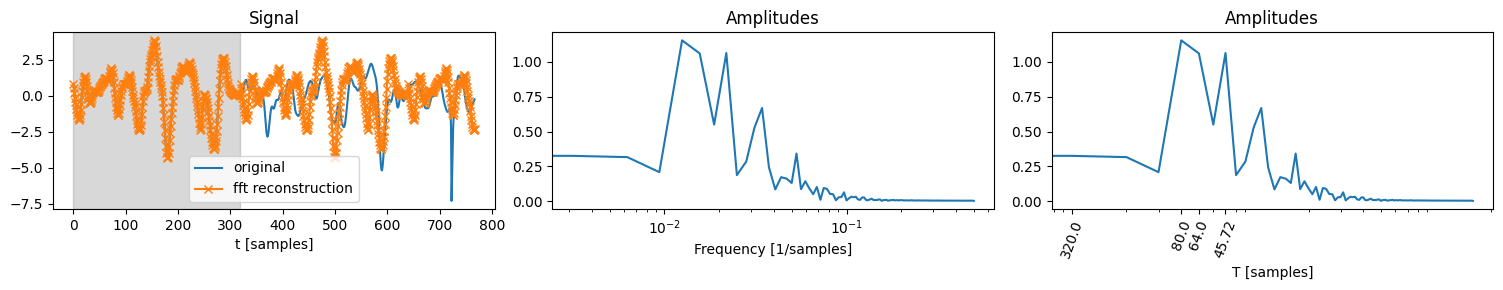

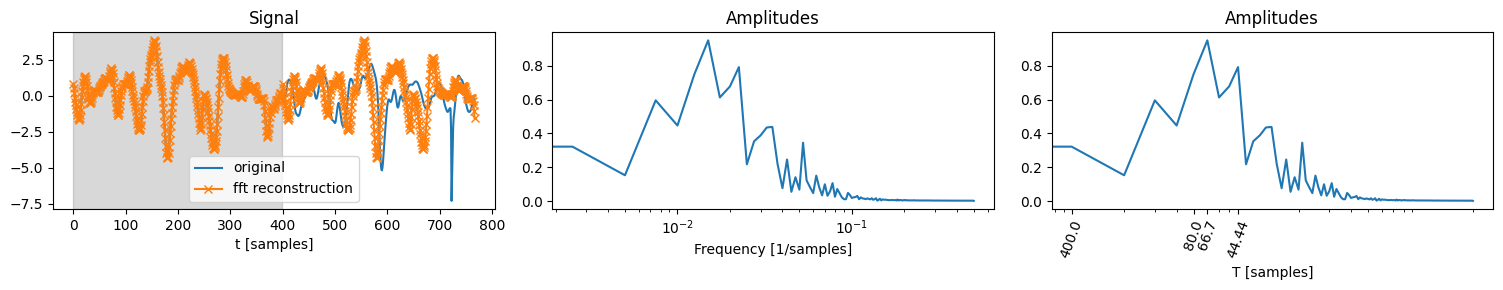

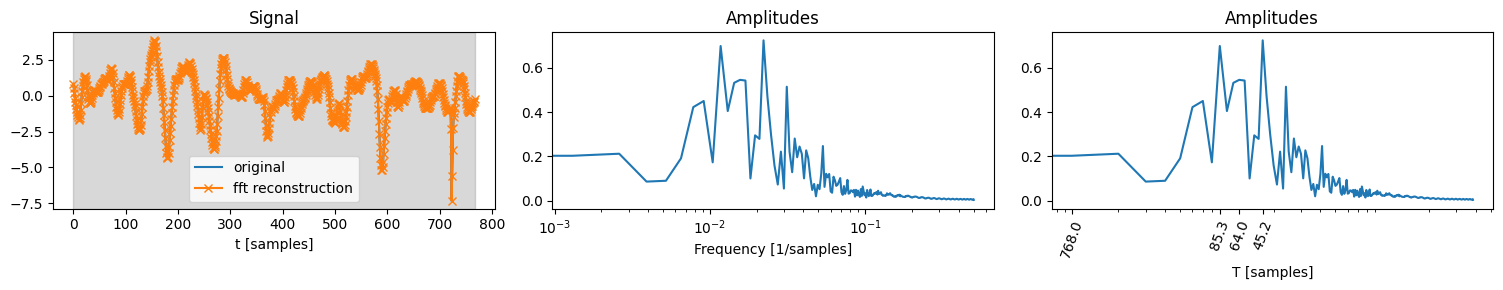

In [8]:
import pandas as pd
import torch

# Replace 'your_file.csv' with the path to your CSV file
# and 'your_column_name' with the name of the column you want to read.
csv_file = './data/data_easier.csv'
column_name = 'target'

# Read the CSV file using pandas
df = pd.read_csv(csv_file)

# Select the column and convert it to a NumPy array
column_data = df[column_name].to_numpy()

# Convert the NumPy array to a PyTorch tensor
targets = torch.tensor(column_data, dtype=torch.float32)  # or torch.float64 for double precision
targets = targets-torch.mean(targets)
print(len(targets))
plot_signal_and_fft(targets, 80)
plot_signal_and_fft(targets, 160)
plot_signal_and_fft(targets, 240)
plot_signal_and_fft(targets, 320)
plot_signal_and_fft(targets, 400)
plot_signal_and_fft(targets, len(targets))

## LSTM

We have looked at how a DFT alone can help us in predicting oiur signals and the anser is, not very well.
So let's see how a very simple LSTM performs.

Let's define the Dataset class that will feed the data to our LSTM during traing and eval.

In [5]:
class SignalDataset(Dataset):
    def __init__(self, size, num_samples=100):
        """
        :param size: Number of samples in the dataset
        """
        self.size = size
        self.num_samples = num_samples

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal(num_samples=self.num_samples)
        # print("__getitem__")
        # Convert to PyTorch tensors
        target = torch.roll(signal, -1, dims=0)
        return signal.unsqueeze_(dim=-1), target.unsqueeze_(dim=-1)

### Small and simple LSTM

Now let's define the LSTM model itself.

In [57]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=1)
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x = self.linear(x)
        return x

Let's inspect our model architetcure and initialize it.

In [66]:
# Nicer summary of model
import random
import string


def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = LSTMPredictor()

pram_count = count_parameters(model)
LR = 0.002
device =  torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE", device)
model.to(device)

checkpoint_path = './checkpoints/4u5vlsd9/500_epochs_4u5vlsd9'
# checkpoint_path = None

if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
    model.load_state_dict(torch.load(checkpoint_path))
else:
    start_epochs = 0

wandb_active = False
run_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    400     |
| lstm.weight_hh_l0 |   40000    |
|  lstm.bias_ih_l0  |    400     |
|  lstm.bias_hh_l0  |    400     |
|   linear.weight   |    100     |
|    linear.bias    |     1      |
+-------------------+------------+
Total Trainable Params: 41301
DEVICE cpu


Optionally we can set up wandb to see how our training progresses.

In [67]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{LR}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb_id = checkpoint_data[-1]

    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

wandb_active = True
run_id = wandb.run.id

Now we are ready to go, we just need to initialize the datasets, data loaders, optimizers and start our trainign loop.

In [68]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SignalDataset(size=1000, num_samples=150) 
val_dataset = SignalDataset(size=1000, num_samples=150)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 500


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq.to(device))
        single_loss = loss_function(y_pred, labels.to(device))
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 25 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq.to(device))
            single_loss = loss_function(y_pred, labels.to(device))
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        if wandb_active:
            wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        if i % 100 == 0:
            Path(f"./checkpoints/{run_id}/").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{run_id}/{i}_epochs_{run_id}')
        

TRAIN: epoch: 500,  loss: 0.2505140006542206
VAL: epoch: 500,  val loss: 0.1839739978313446 



wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 500 is less than current step: 501. Dropping entry: {'train loss': 0.2505140006542206, 'val loss': 0.1839739978313446, '_timestamp': 1711792702.073743}).


TRAIN: epoch: 525,  loss: 0.13927938044071198
VAL: epoch: 525,  val loss: 0.13571178913116455 

TRAIN: epoch: 550,  loss: 0.13757704198360443
VAL: epoch: 550,  val loss: 0.13743481040000916 

TRAIN: epoch: 575,  loss: 0.1452784240245819
VAL: epoch: 575,  val loss: 0.14191418886184692 

TRAIN: epoch: 600,  loss: 0.138040229678154
VAL: epoch: 600,  val loss: 0.13737215101718903 

TRAIN: epoch: 625,  loss: 0.13676045835018158
VAL: epoch: 625,  val loss: 0.13373471796512604 

TRAIN: epoch: 650,  loss: 0.13470761477947235
VAL: epoch: 650,  val loss: 0.1365266740322113 

TRAIN: epoch: 675,  loss: 0.13040682673454285
VAL: epoch: 675,  val loss: 0.13155266642570496 

TRAIN: epoch: 700,  loss: 0.14269015192985535
VAL: epoch: 700,  val loss: 0.13750886917114258 

TRAIN: epoch: 725,  loss: 0.13795575499534607
VAL: epoch: 725,  val loss: 0.1334671825170517 

TRAIN: epoch: 750,  loss: 0.13537853956222534
VAL: epoch: 750,  val loss: 0.13219575583934784 

TRAIN: epoch: 775,  loss: 0.15944494307041168

In [69]:
if wandb_active:    
    wandb.finish()

wandb: WARNING Ensure read and write access to run files dir: /Users/roncaglionidaniele/Documents/projects/time-series-prediciton/wandb/run-20240330_105808-4u5vlsd9/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


train loss,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁█▂▂
val loss,▁▂▂▂▁▁▁▂▁▁▂▁▁▂▁▁▂█▃▃
train loss,0.15818
val loss,0.16309


In [8]:
# model.load_state_dict(torch.load("checkpoints/0a4eos6o/500_epochs_0a4eos6o"))

<All keys matched successfully>

Let's see how our model performs.

First of all we need to rememebr that if we feed a sequence to an LSTM model, then the prediction at point `n+1` will be based on all points before that. So when plotting the prediction the LSTM can't really mess up that much since at each step we predict on all the previous actual grounf truth values.

No surpise then that the plot looks pretty good.

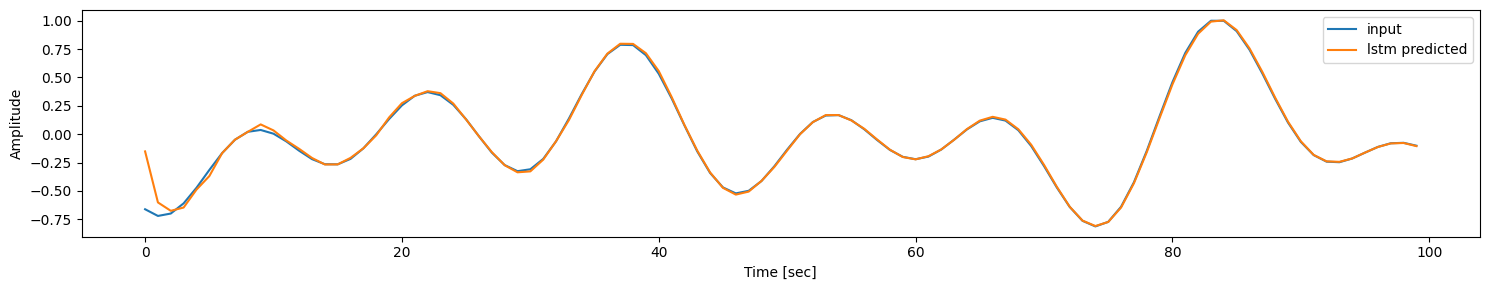

In [70]:
t, signal = generate_signal(num_samples=100)
pred = model(signal.view(1, len(signal), 1))
predicted_signal = pred.view(len(signal)).detach()
predicted_signal = torch.roll(predicted_signal, 1, dims=0)

# Plotting
plt.figure(figsize=(15, 3))

plt.plot(t, signal, label='input')
plt.plot(t, predicted_signal, label='lstm predicted')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

The real test is autoregressive generation, where we give the LSTM a part of the ground truth, and then use the LSTMs own output for step `n` to also predict `n+1` etc.

Let's see how we do in that case.

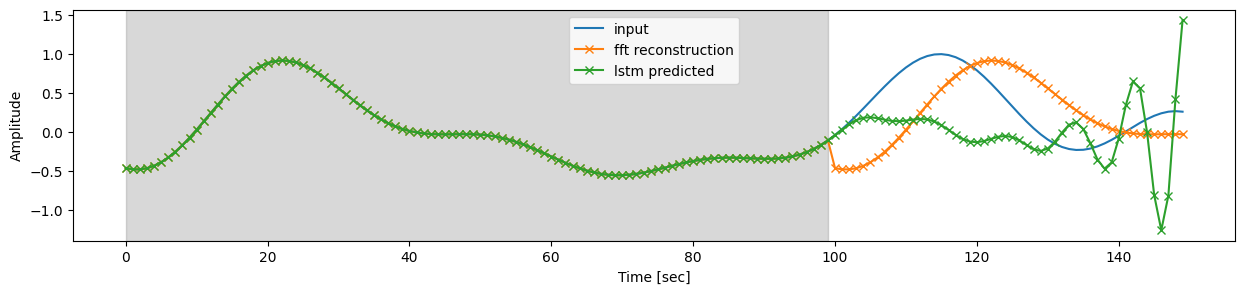

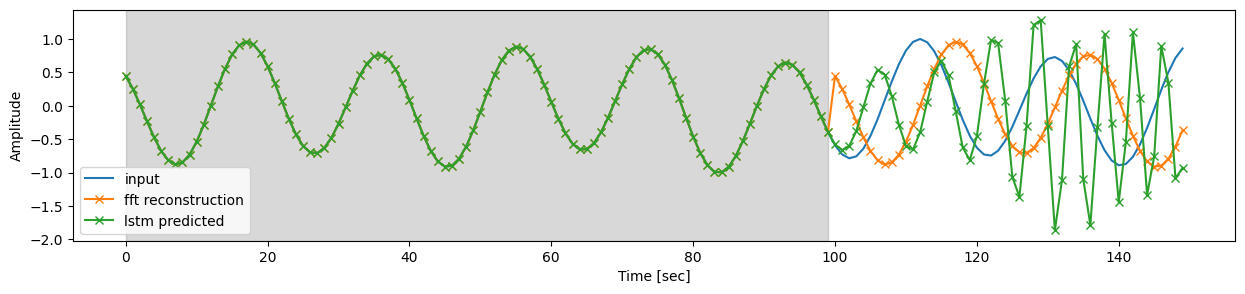

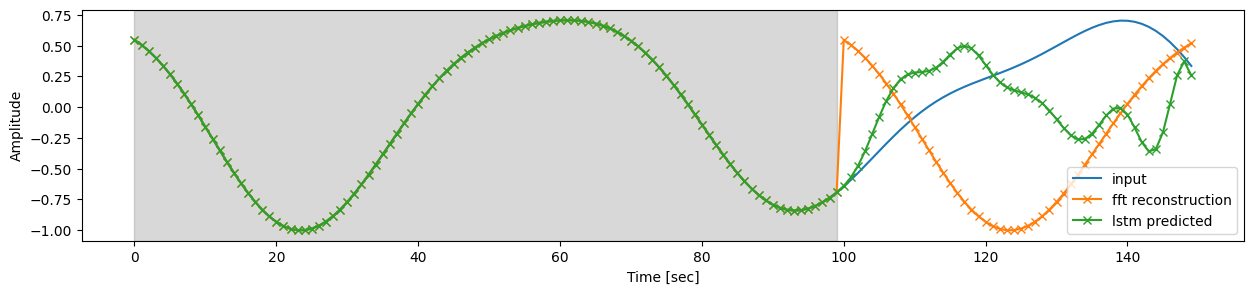

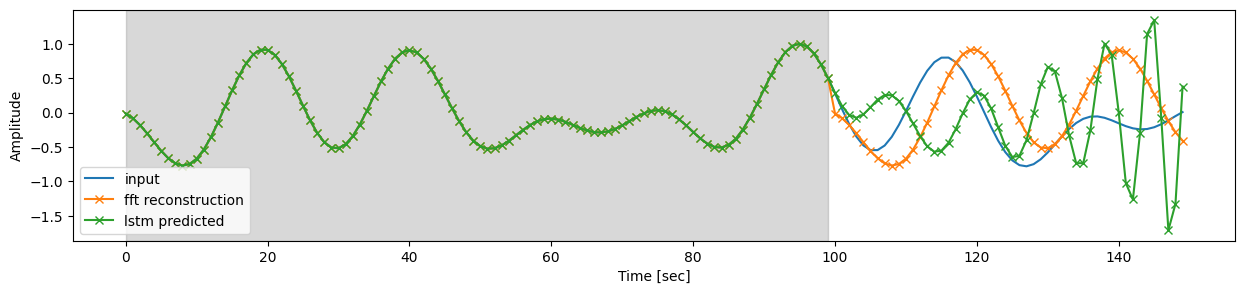

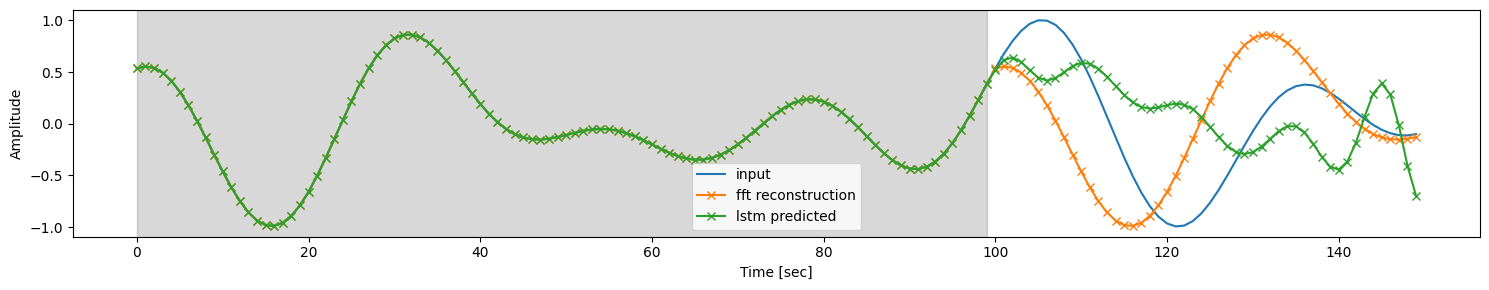

In [71]:
def lstm_autoregressive_pred(signal, N):
    signal_continuation_autoreg = torch.clone(signal)
    signal_continuation_autoreg[N:] = 0
    for i in range(len(signal[N:])):
        pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
        pred = pred.view(len(signal_continuation_autoreg)).detach()
        signal_continuation_autoreg[N+i] = pred[N+i-1]
    return signal_continuation_autoreg

N=100
for _ in range(5):
    t, signal = generate_signal(num_samples=150)
    plt.figure(figsize=(15, 3))

    plt.plot(t, signal, label='input')
    plt.plot(t, reconstruct_signal_fft(signal, N),'-x', label='fft reconstruction')
    plt.plot(t, lstm_autoregressive_pred(signal,N),'-x', label='lstm predicted')
    plt.legend(loc='best')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    plt.axvspan(0, N-1, color='grey', alpha=0.3)


plt.tight_layout()
plt.show()

This isn't doing very well, and the loss curves are already plateauing.

### More ambitious LSTM architecture


In [73]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.linear_2 = torch.nn.Linear(int(hidden_layer_size/2), output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x =  self.leaky_relu(x)
        x = self.linear_1(x)
        x = self.leaky_relu(x)
        x = self.linear_2(x)
        return x

In [74]:
# Nicer summary of model
import random
import string


def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = LSTMPredictor()

pram_count = count_parameters(model)
LR = 0.002
device =  torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE", device)
model.to(device)

# checkpoint_path = './checkpoints/4u5vlsd9/500_epochs_4u5vlsd9'
checkpoint_path = None

if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
    model.load_state_dict(torch.load(checkpoint_path))
else:
    start_epochs = 0

wandb_active = False
run_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    800     |
| lstm.weight_hh_l0 |   160000   |
|  lstm.bias_ih_l0  |    800     |
|  lstm.bias_hh_l0  |    800     |
| lstm.weight_ih_l1 |   160000   |
| lstm.weight_hh_l1 |   160000   |
|  lstm.bias_ih_l1  |    800     |
|  lstm.bias_hh_l1  |    800     |
|  linear_1.weight  |   20000    |
|   linear_1.bias   |    100     |
|  linear_2.weight  |    100     |
|   linear_2.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 504201
DEVICE cpu


In [75]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{LR}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb_id = checkpoint_data[-1]

    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

wandb_active = True
run_id = wandb.run.id

In [76]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SignalDataset(size=1000, num_samples=150) 
val_dataset = SignalDataset(size=1000, num_samples=150)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 1000


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq.to(device))
        single_loss = loss_function(y_pred, labels.to(device))
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 25 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq.to(device))
            single_loss = loss_function(y_pred, labels.to(device))
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        if wandb_active:
            wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        if i % 100 == 0:
            Path(f"./checkpoints/{run_id}/").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{run_id}/{i}_epochs_{run_id}')
        

TRAIN: epoch: 0,  loss: 3.471526622772217
VAL: epoch: 0,  val loss: 1.681085467338562 

TRAIN: epoch: 25,  loss: 0.2073584794998169
VAL: epoch: 25,  val loss: 0.183948814868927 

TRAIN: epoch: 50,  loss: 0.15181434154510498
VAL: epoch: 50,  val loss: 0.15747828781604767 

TRAIN: epoch: 75,  loss: 0.15282930433750153
VAL: epoch: 75,  val loss: 0.15657880902290344 

TRAIN: epoch: 100,  loss: 0.1374671906232834
VAL: epoch: 100,  val loss: 0.14472688734531403 

TRAIN: epoch: 125,  loss: 0.13240879774093628
VAL: epoch: 125,  val loss: 0.1264638602733612 

TRAIN: epoch: 150,  loss: 0.13373233377933502
VAL: epoch: 150,  val loss: 0.12571106851100922 

TRAIN: epoch: 175,  loss: 0.1356796771287918
VAL: epoch: 175,  val loss: 0.1342470943927765 

TRAIN: epoch: 200,  loss: 0.1333586424589157
VAL: epoch: 200,  val loss: 0.13922052085399628 

TRAIN: epoch: 225,  loss: 0.13786257803440094
VAL: epoch: 225,  val loss: 0.14242088794708252 

TRAIN: epoch: 250,  loss: 0.1320585310459137
VAL: epoch: 250, 

KeyboardInterrupt: 

In [78]:
if wandb_active:    
    wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,0.12544
val loss,0.12641


In [77]:
model.load_state_dict(torch.load("checkpoints/8q547s9d/800_epochs_8q547s9d"))

<All keys matched successfully>

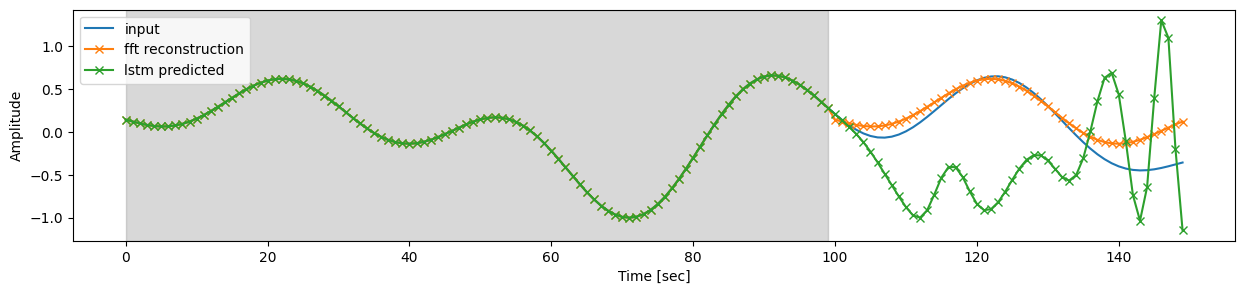

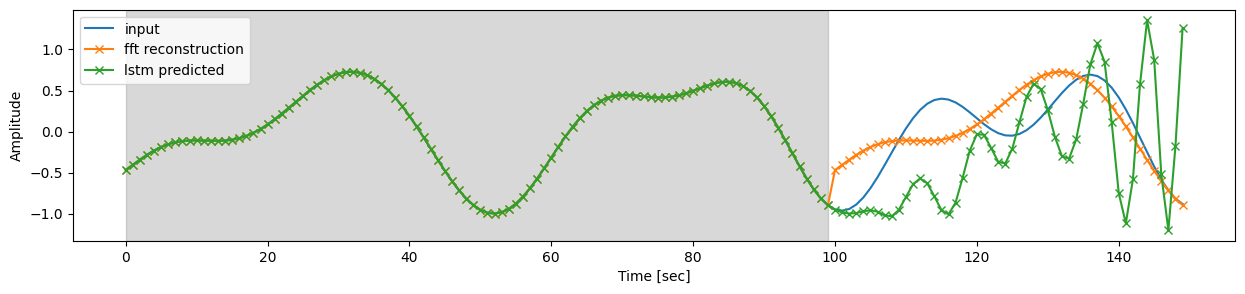

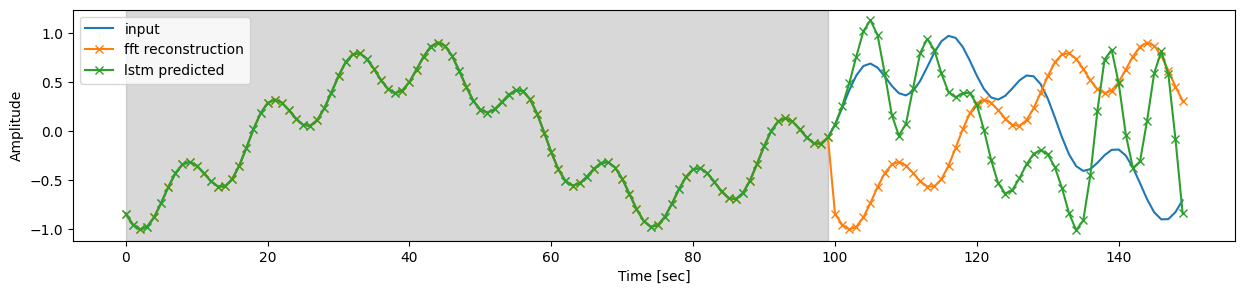

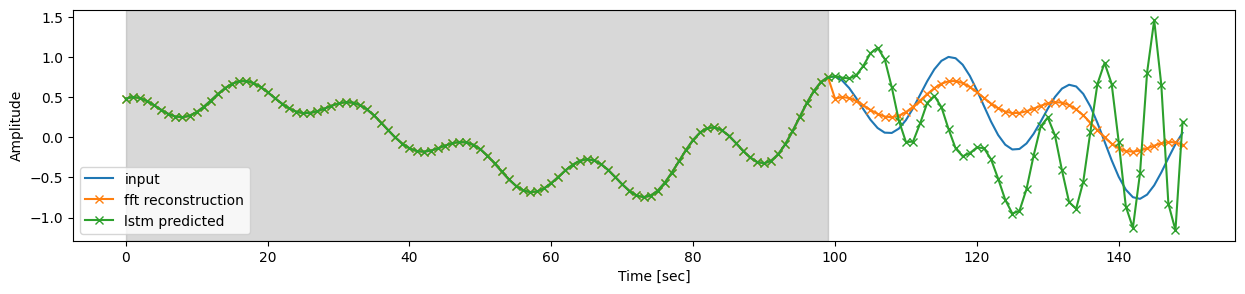

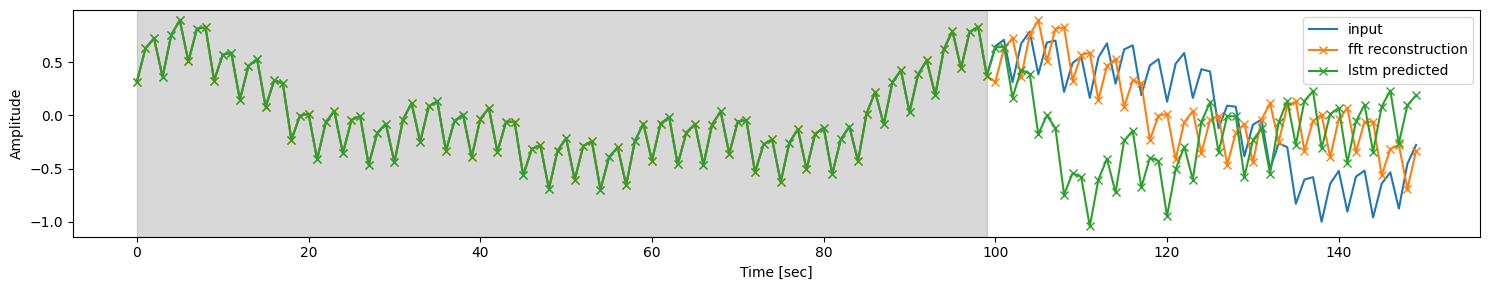

In [79]:
def lstm_autoregressive_pred(signal, N):
    signal_continuation_autoreg = torch.clone(signal)
    signal_continuation_autoreg[N:] = 0
    for i in range(len(signal[N:])):
        pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
        pred = pred.view(len(signal_continuation_autoreg)).detach()
        signal_continuation_autoreg[N+i] = pred[N+i-1]
    return signal_continuation_autoreg

N=100
for _ in range(5):
    t, signal = generate_signal(num_samples=150)
    plt.figure(figsize=(15, 3))

    plt.plot(t, signal, label='input')
    plt.plot(t, reconstruct_signal_fft(signal, N),'-x', label='fft reconstruction')
    plt.plot(t, lstm_autoregressive_pred(signal,N),'-x', label='lstm predicted')
    plt.legend(loc='best')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    plt.axvspan(0, N-1, color='grey', alpha=0.3)


plt.tight_layout()
plt.show()

Still bad.

### Sequence to Sequence

Perhaps the problem is that we are trying to use the model autoregressively to predict a longer sequence, even though it was trained to only ever make a prediction for the next element.

Let's try a different model architecture, one where we actually train it to produce a longer sequence directly.
Do to dis welll use an LSTM to encode the lookback window into a hidden state and we'll use another LSTM to decode that into the predicted seuquence.

In [7]:
class SeqToSeqDataset(Dataset):
    def __init__(self, size, num_samples=150, split_idx=100):
        assert num_samples > split_idx
        self.size = size
        self.num_samples = num_samples
        self.split_idx = split_idx

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal(num_samples=self.num_samples, periods_range=(2,20))#, num_components=1, periods_range=5)
        encoder_input = signal[:self.split_idx]
        decoder_input = signal[self.split_idx-1:]
        decoder_targets = torch.roll(decoder_input, -1, dims=0)
        return encoder_input.unsqueeze_(dim=-1), decoder_input[:-1].unsqueeze_(dim=-1), decoder_targets[:-1].unsqueeze_(dim=-1)

In [69]:
dataset= SeqToSeqDataset(1000, num_samples=10, split_idx=6)
encoder_input, decoder_input, decoder_targets = next(iter(dataset))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
class GruEncoder(torch.nn.Module):
    def __init__(self, hidden_size) -> None:
        super(GruEncoder, self).__init__()
        self.gru = torch.nn.GRU(input_size=1, hidden_size=hidden_size, batch_first=True, num_layers=1)
        
    def forward(self, encoder_input):
        """
        Args:
            encoder_input: torch.Tensor[N, L_encoder, 1]

        Returns:
            torch.Tensor: [N, h_encoder + fft]
        """    
        _, h_n = self.gru(encoder_input) # h_n =[1, N, h_dim]
        fft_result = torch.fft.rfft(encoder_input, dim=1, norm="forward")
        amplitudes = torch.abs(fft_result) # = [N, f_dim, 1]
        phases =  torch.angle(fft_result)
        return torch.concat((h_n, amplitudes.view(1,encoder_input.shape[0],-1), phases.view(1,encoder_input.shape[0],-1)), dim=-1).squeeze_(dim=0)
    
class GruDecoderCell(torch.nn.Module):
    def __init__(self, hidden_size) -> None:
        super(GruDecoderCell, self).__init__()
        self.gru_cell = torch.nn.GRUCell(input_size=1, hidden_size=hidden_size)
    
    def forward(self, input, h):    
        return self.gru_cell(input, h)
    

class SeqToSeqGru(torch.nn.Module):
    def __init__(self, encoder_input_length=100, decoder_input_length=50) -> None:
        super(SeqToSeqGru, self).__init__()
        self.encoder_in_dim = encoder_input_length
        self.decoder_in_dim = decoder_input_length
        
        self.encoder_hidden_dim = 100
        self.enocoder_output_dim = self.encoder_hidden_dim + 2*(int(self.encoder_in_dim/2) + 1) # hidden dim + cat 2 * rfft

        self.encoder = GruEncoder(hidden_size=self.encoder_hidden_dim)
        self.decoder_cell = GruDecoderCell(hidden_size=self.enocoder_output_dim)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(self.enocoder_output_dim, int(self.enocoder_output_dim/2))
        self.linear_2 = torch.nn.Linear(int(self.enocoder_output_dim/2), 1) 
        
    def forward(self, encoder_input, decoder_input=None):
        """
        Args:
            encoder_input: torch.Tensor[N, L_encoder, 1]
            decoder_input: torch.Tensor[N, L_decoder, 1] | None 

        Returns:
            torch.Tensor: [L_decoder, 1]
        """        
        # assert encoder_input.shape[1] == self.encoder_in_dim
        # assert decoder_input.shape[1] == self.decoder_in_dim

        # Compress all of lookback window into hidden state with encoder and concat with fft
        h_n_augemented = self.encoder(encoder_input) # [N, h_encoder + fft]
        
        # init hidden state for decoder is the compressed lookback window hidden state from the encoder   
        h_decoder = h_n_augemented
        decoder_outputs = torch.empty((encoder_input.shape[0], self.decoder_in_dim, h_n_augemented.shape[-1]), dtype=torch.float) # [N, dec_in, h_enc+fft] 
        mlp_outputs = torch.empty((encoder_input.shape[0], self.decoder_in_dim, 1), dtype=torch.float) # [N, dec_in, 1] 
        # teacher forcing: feed actual sequence to decoder
        if decoder_input is not None: # Loop over inputs and feed them to decoder cell while updating the hidden state
            for i in range(self.decoder_in_dim):
                input_element = decoder_input[:,i,:]
                h_decoder = self.decoder_cell(input_element, h_decoder) # [N, h_enc + fft]
                decoder_outputs[:, i, :] = h_decoder
            x = self.linear_1(decoder_outputs)
            x = self.leaky_relu(x)
            x = self.linear_2(x)
            return x
        else: # No teacher forcing: autoregress
            # init the autoregression with the last value in the lookback window
            decoder_input = encoder_input[:,-1,:] #
            for i in range(self.decoder_in_dim):
                h_decoder = self.decoder_cell(decoder_input, h_decoder)
                # decoder_outputs[:, i, :] = h_decoder
                x = self.linear_1(h_decoder)
                x = self.leaky_relu(x)
                x = self.linear_2(x)
                decoder_input = x.clone().detach()
                mlp_outputs[:, i, :] = x
            return mlp_outputs
 



In [68]:
model = SeqToSeqGru(encoder_input_length=6, decoder_input_length=4)
enocder_inputs, decoder_inputs, targs = next(iter(dataloader))
model(enocder_inputs)

tensor([[[-0.1169],
         [-0.1178],
         [-0.1151],
         [-0.1129]],

        [[-0.1285],
         [-0.1233],
         [-0.1151],
         [-0.1117]],

        [[-0.1169],
         [-0.1178],
         [-0.1150],
         [-0.1129]],

        [[-0.1228],
         [-0.1118],
         [-0.1055],
         [-0.1048]],

        [[-0.1220],
         [-0.1210],
         [-0.1145],
         [-0.1117]],

        [[-0.1215],
         [-0.1184],
         [-0.1150],
         [-0.1131]],

        [[-0.1236],
         [-0.1170],
         [-0.1110],
         [-0.1085]],

        [[-0.1539],
         [-0.1337],
         [-0.1211],
         [-0.1159]],

        [[-0.1404],
         [-0.1260],
         [-0.1178],
         [-0.1147]],

        [[-0.1280],
         [-0.1231],
         [-0.1151],
         [-0.1117]],

        [[-0.1490],
         [-0.1280],
         [-0.1160],
         [-0.1106]],

        [[-0.1448],
         [-0.1364],
         [-0.1256],
         [-0.1173]],

        [[-0.147

In [10]:
# Nicer summary of model
import random
import string


def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = SeqToSeqGru(encoder_input_length=20, decoder_input_length=5)

pram_count = count_parameters(model)
LR = 0.002
device =  torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE", device)
model.to(device)

# checkpoint_path = './checkpoints/4u5vlsd9/500_epochs_4u5vlsd9'
checkpoint_path = None

if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
    model.load_state_dict(torch.load(checkpoint_path))
else:
    start_epochs = 0

wandb_active = False
run_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))


+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     encoder.gru.weight_ih_l0    |    300     |
|     encoder.gru.weight_hh_l0    |   30000    |
|      encoder.gru.bias_ih_l0     |    300     |
|      encoder.gru.bias_hh_l0     |    300     |
| decoder_cell.gru_cell.weight_ih |    366     |
| decoder_cell.gru_cell.weight_hh |   44652    |
|  decoder_cell.gru_cell.bias_ih  |    366     |
|  decoder_cell.gru_cell.bias_hh  |    366     |
|         linear_1.weight         |    7442    |
|          linear_1.bias          |     61     |
|         linear_2.weight         |     61     |
|          linear_2.bias          |     1      |
+---------------------------------+------------+
Total Trainable Params: 84215
DEVICE cpu


In [11]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{LR}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb_id = checkpoint_data[-1]

    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

wandb_active = True
run_id = wandb.run.id

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roncaglionidaniele (shape-vs-texture). Use `wandb login --relogin` to force relogin


In [12]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SeqToSeqDataset(size=1000, num_samples=25, split_idx=20) 
val_dataset = SeqToSeqDataset(size=1000, num_samples=25, split_idx=20)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 1500


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for encoder_input, decoder_input, targets in dataloader:
        optimizer.zero_grad()
        y_pred = model(encoder_input.to(device), decoder_input.to(device))
        single_loss = loss_function(y_pred, targets.to(device))
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 25 == 0:
        model.eval()
        val_loss = 0
        for encoder_input, decoder_input, targets in val_dataloader:
            y_pred = model(encoder_input.to(device))
            single_loss = loss_function(y_pred, targets.to(device))
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        if wandb_active:
            wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        if i % 100 == 0:
            Path(f"./checkpoints/{run_id}/").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{run_id}/{i}_epochs_{run_id}')
        

TRAIN: epoch: 0,  loss: 6.581963539123535
VAL: epoch: 0,  val loss: 5.967068195343018 

TRAIN: epoch: 25,  loss: 0.6415933966636658
VAL: epoch: 25,  val loss: 2.0274245738983154 

TRAIN: epoch: 50,  loss: 0.3098479211330414
VAL: epoch: 50,  val loss: 1.7044411897659302 

TRAIN: epoch: 75,  loss: 0.2048838585615158
VAL: epoch: 75,  val loss: 1.3844306468963623 

TRAIN: epoch: 100,  loss: 0.15783075988292694
VAL: epoch: 100,  val loss: 1.0461561679840088 

TRAIN: epoch: 125,  loss: 0.1540810465812683
VAL: epoch: 125,  val loss: 1.3513855934143066 

TRAIN: epoch: 150,  loss: 0.11967878043651581
VAL: epoch: 150,  val loss: 1.0410690307617188 

TRAIN: epoch: 175,  loss: 0.11049529910087585
VAL: epoch: 175,  val loss: 0.8351616859436035 

TRAIN: epoch: 200,  loss: 0.12447955459356308
VAL: epoch: 200,  val loss: 1.097184419631958 

TRAIN: epoch: 225,  loss: 0.0891304537653923
VAL: epoch: 225,  val loss: 0.8258245587348938 

TRAIN: epoch: 250,  loss: 0.09471600502729416
VAL: epoch: 250,  val l

In [13]:
if wandb_active:    
    wandb.finish()

train loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,0.02502
val loss,0.46642


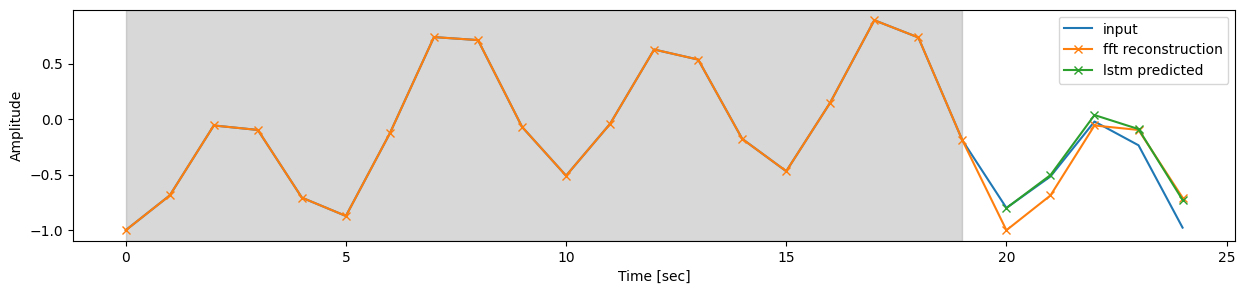

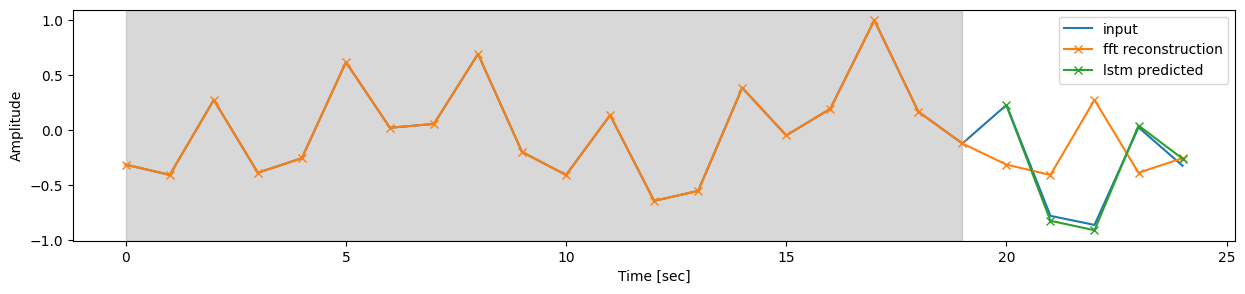

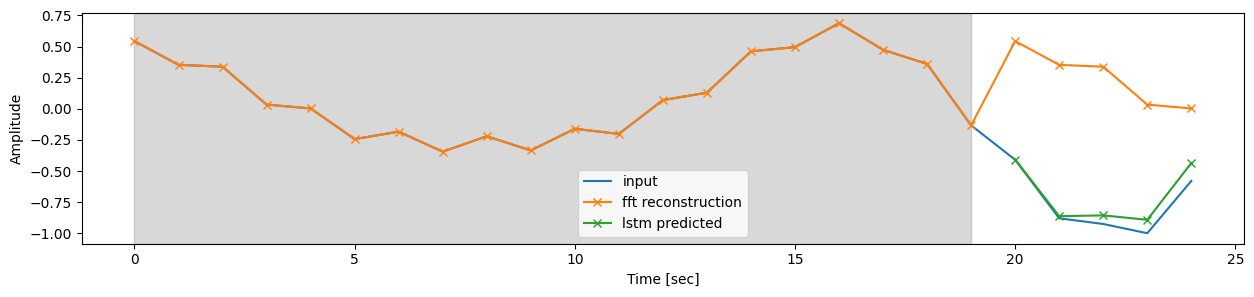

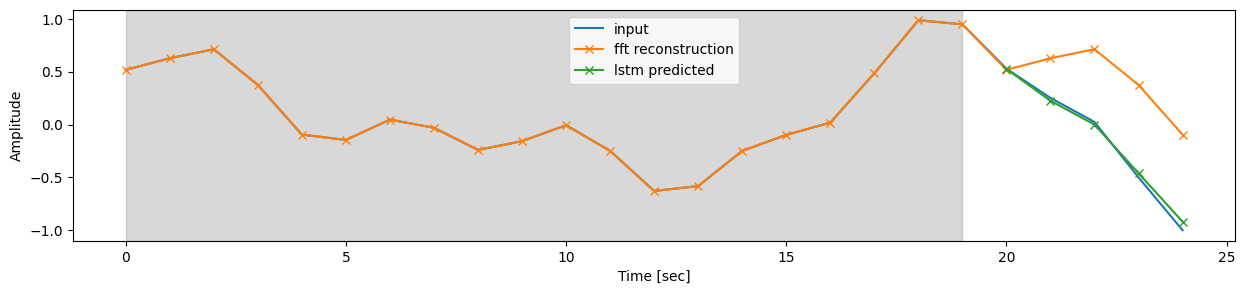

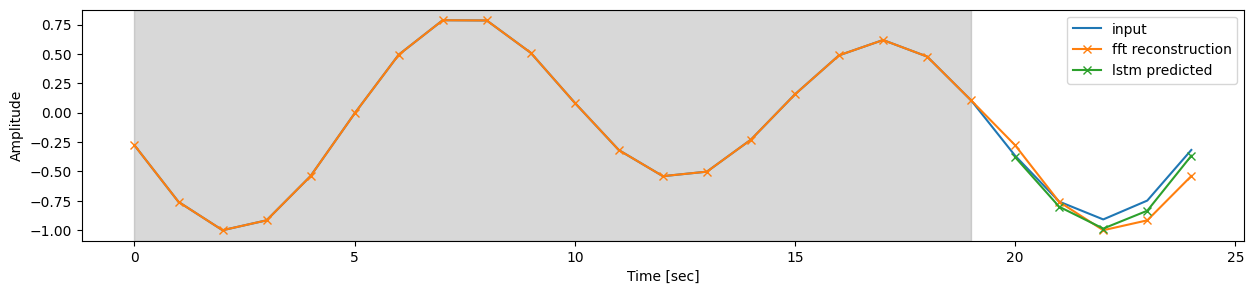

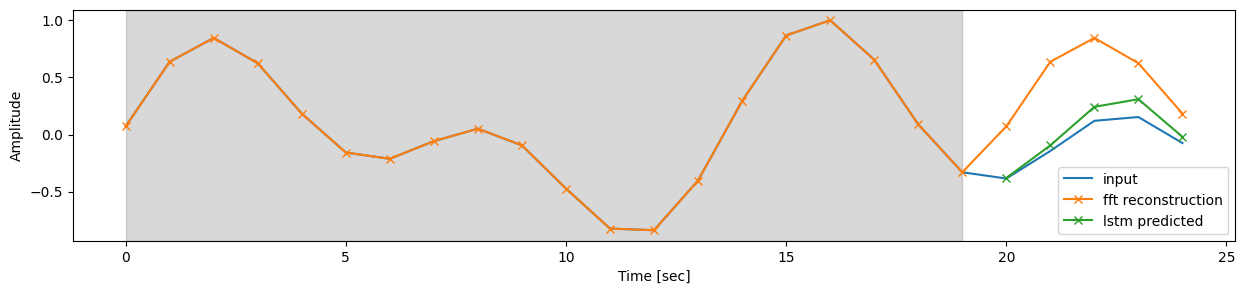

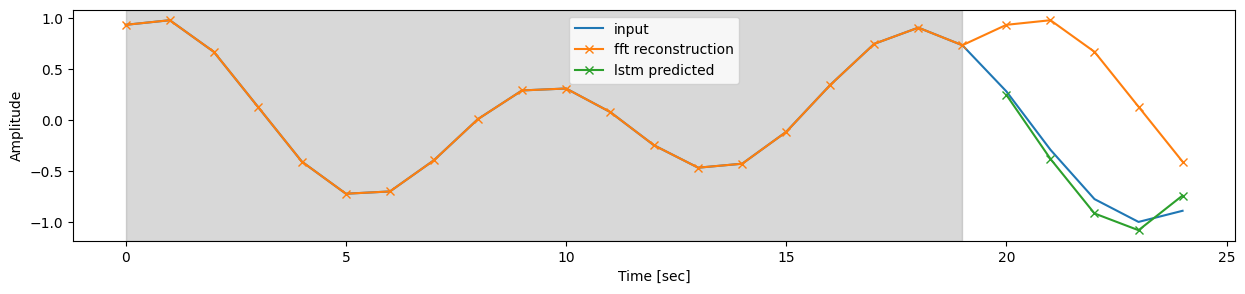

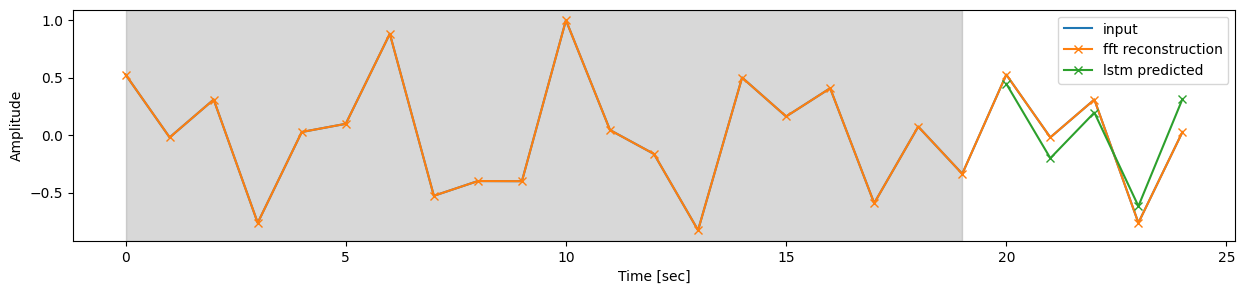

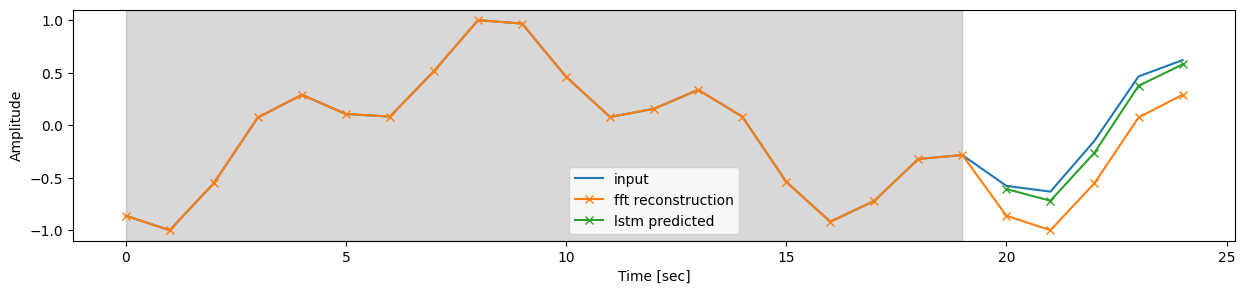

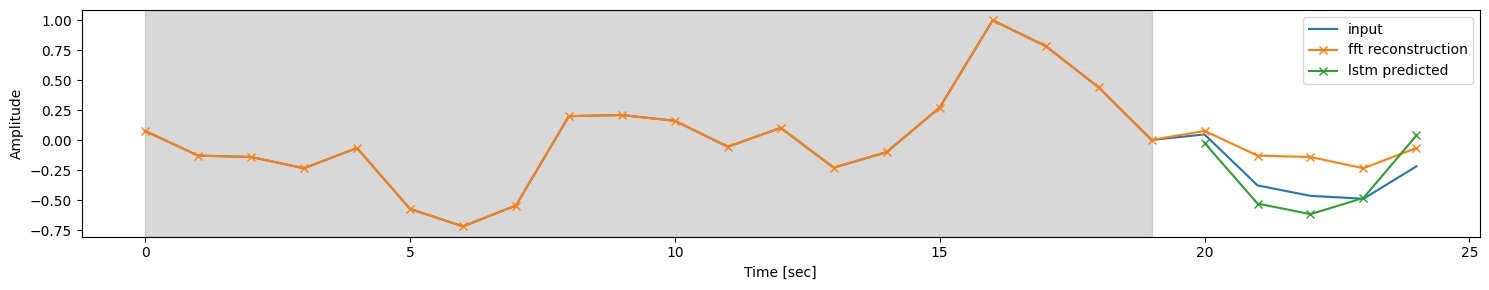

In [22]:
def lstm_autoregressive_pred(signal, N):
    signal = torch.clone(signal)
    pred = model(signal[:N].view(1,N,1))
    return pred.view(25-N).detach()

N=20
for _ in range(10):
    t, signal = generate_signal(num_samples=25, periods_range=(2,20))
    plt.figure(figsize=(15, 3))

    plt.plot(t, signal, label='input')
    plt.plot(t, reconstruct_signal_fft(signal, N),'-x', label='fft reconstruction')
    plt.plot(range(20,25), lstm_autoregressive_pred(signal,N),'-x', label='lstm predicted')
    plt.legend(loc='best')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    plt.axvspan(0, N-1, color='grey', alpha=0.3)


plt.tight_layout()
plt.show()